<a href="https://colab.research.google.com/github/sgroenjes/BERT-emotions/blob/main/BERT_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 13.4 MB/s 
     |████████████████████████████████| 1.8 MB 6.2 MB/s 
     |████████████████████████████████| 116 kB 60.9 MB/s 
     |████████████████████████████████| 99 kB 6.7 MB/s 
     |████████████████████████████████| 238 kB 49.2 MB/s 
     |████████████████████████████████| 1.1 MB 21.4 MB/s 
     |████████████████████████████████| 43 kB 1.3 MB/s 
     |████████████████████████████████| 1.3 MB 62.0 MB/s 
     |████████████████████████████████| 352 kB 70.3 MB/s 


In [ ]:
import os
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
# goemotions doesn't offer as_supervised at this time
(ds, valds), info = tfds.load('goemotions', split=['train', 'test'], shuffle_files=True, with_info=True)
tfds.as_dataframe(ds.take(4), info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/43410 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incomplete8BR1QR/goemotions-train.tfrecord*...:   0%|        …

Generating validation examples...:   0%|          | 0/5426 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incomplete8BR1QR/goemotions-validation.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/5427 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/goemotions/0.1.0.incomplete8BR1QR/goemotions-test.tfrecord*...:   0%|         …

Dataset goemotions downloaded and prepared to ~/tensorflow_datasets/goemotions/0.1.0. Subsequent calls will reuse this data.


,admiration,amusement,anger,annoyance,approval,caring,comment_text,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,neutral,optimism,pride,realization,relief,remorse,sadness,surprise
0,False,False,False,False,False,False,"It's just wholesome content, from questionable sources",False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,True,False,False,False,False,False,This is actually awesome.,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,People really spend more than $10 in an app game? I mean an actual video game I can understand but that's just...sad,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,I grew up on the other side of Ama but live in Tulia now. I will have some El Burrito for you,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [ ]:
df = tfds.as_dataframe(ds.take(1), info)
print(df)
print(info.features)

   admiration  amusement  anger  annoyance  approval  caring  \
0       False      False  False      False     False   False   

                                        comment_text  confusion  curiosity  \
0  b"It's just wholesome content, from questionab...      False      False   

   desire  ...   love  nervousness  neutral  optimism  pride  realization  \
0   False  ...  False        False     True     False  False        False   

   relief  remorse  sadness  surprise  
0   False    False    False     False  

[1 rows x 29 columns]
FeaturesDict({
    'admiration': tf.bool,
    'amusement': tf.bool,
    'anger': tf.bool,
    'annoyance': tf.bool,
    'approval': tf.bool,
    'caring': tf.bool,
    'comment_text': Text(shape=(), dtype=tf.string),
    'confusion': tf.bool,
    'curiosity': tf.bool,
    'desire': tf.bool,
    'disappointment': tf.bool,
    'disapproval': tf.bool,
    'disgust': tf.bool,
    'embarrassment': tf.bool,
    'excitement': tf.bool,
    'fear': tf.bool,
   

In [ ]:
LABELS = [
    'admiration', 
    'amusement', 
    'anger', 
    'annoyance', 
    'approval', 
    'caring',
    'confusion', 
    'curiosity', 
    'desire', 
    'disappointment', 
    'disapproval', 
    'disgust', 
    'embarrassment', 
    'excitement', 
    'fear', 
    'gratitude', 
    'grief', 
    'joy', 
    'love', 
    'nervousness', 
    'neutral', 
    'optimism', 
    'pride', 
    'realization', 
    'relief', 
    'remorse', 
    'sadness', 
    'surprise'
]
print(f"Number of emotions: {len(LABELS)}")
NUM_EMOTIONS = len(LABELS)

Number of emotions: 28


In [ ]:
def preprocessing(dataset):
  x = []
  y = []
  for example in dataset:
    x.append(example['comment_text'])
    del example['comment_text']
    one_hot_array = [1 if x else 0 for x in list(example.values())]
    y.append(tf.one_hot(one_hot_array.index(1), NUM_EMOTIONS))
  return np.stack(np.array([np.array(val) for val in x]),axis=-1), np.array(y).astype('float32')
x_train, y_train = preprocessing(ds)
x_val, y_val = preprocessing(valds)

In [ ]:
# display data distribution

In [ ]:
print(x_train[0:5])
print(y_train[0:5])
print(f"{len(x_train)} {len(y_train)}")
print(f"{len(x_val)} {len(y_val)}")
print(f"x_train.shape {x_train.shape} {x_train.dtype}")
print(f"y_train.shape {y_train.shape} {y_train.dtype}")
print(f"x_val.shape {x_val.shape} {x_val.dtype}")
print(f"y_val.shape {y_val.shape} {y_val.dtype}")

[b"It's just wholesome content, from questionable sources"
 b'This is actually awesome.'
 b"People really spend more than $10 in an app game? I mean an actual video game I can understand but that's just...sad"
 b'I grew up on the other side of Ama but live in Tulia now. I will have some El Burrito for you'
 b'What the problem? I mean, steak? Good. Doughnuts? Good!! I don\xe2\x80\x99t see an issue. ']
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]]
43410 43410
5427 5427
x_train.shape (43410,) object
y_train.shape (43410, 28) float32
x_val.shape (5427,) object
y_val.shape (5427, 28) float32


In [ ]:
print(('Your TensorFlow version: {0}').format(tf.__version__))

Your TensorFlow version: 2.8.2


In [ ]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
# Test it out
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611856  0.36673826  0.15233693  0.65504473
  0.9681154  -0.94862705  0.0021619  -0.9877732   0.06842698 -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321284  0.3323149  ...  0.21300808  0.71020824
  -0.05771172]
 [-0.2874203   0.31981018 -0.2301853  ...  0.58455014 -0.21329692
   0.7269214 ]
 [-0.66157     0.6887689  -0.8743298  ...  0.10877271 -0.26173168
   0.47855347]
 ...
 [-0.22561166 -0.28925633 -0.07064366 ...  0.47566074  0.83277154
   0.4002533 ]
 [-0.29824263 -0.2747314  -0.05450518 ...  0.48849723  1.095536
   0.18163356]
 [-0.443782    0.00930692  0.07223746 ...  0.17290054  1.1833245
   0.07897988]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(NUM_EMOTIONS, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = classifier_model.fit(x=x_train,
                               y=y_train,
                               validation_data=(x_val,y_val),
                               epochs=15)

Epoch 1/15
1357/1357 [==============================] - 233s 170ms/step - loss: 1.4730 - categorical_accuracy: 0.5606 - val_loss: 1.4851 - val_categorical_accuracy: 0.5633
Epoch 2/15
1357/1357 [==============================] - 231s 170ms/step - loss: 1.4602 - categorical_accuracy: 0.5638 - val_loss: 1.4827 - val_categorical_accuracy: 0.5615
Epoch 3/15
1357/1357 [==============================] - 229s 169ms/step - loss: 1.4499 - categorical_accuracy: 0.5675 - val_loss: 1.4715 - val_categorical_accuracy: 0.5708
Epoch 4/15
1357/1357 [==============================] - 230s 169ms/step - loss: 1.4318 - categorical_accuracy: 0.5702 - val_loss: 1.4748 - val_categorical_accuracy: 0.5638
Epoch 5/15
1357/1357 [==============================] - 229s 169ms/step - loss: 1.4154 - categorical_accuracy: 0.5736 - val_loss: 1.4602 - val_categorical_accuracy: 0.5720
Epoch 6/15
1357/1357 [==============================] - 232s 171ms/step - loss: 1.3931 - categorical_accuracy: 0.5797 - val_loss: 1.4583 - v

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


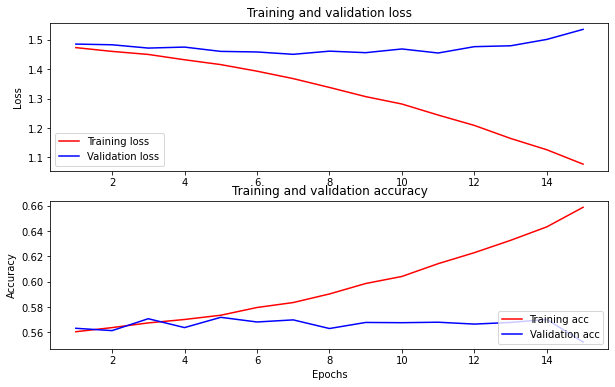

In [ ]:
# view errors
history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'emotions'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
examples = [
    'I want a hug.',
    'I need you to take out the trash.',
    'I need to vent about something.',
    'I did not get enough sleep last night.',
    'Come meet me in the bedroom.',
    'Come give me a kiss.',
    'Help me put away dishes.',
    'You look cute.',
    'I am so happy to see you.',
    'Thank you for back scratches.',
    'I do not like the way he talked to me.'
]

# reloaded_results = reloaded_model(tf.constant(examples))
original_results = classifier_model(tf.constant(examples))

# print('Results from the saved model:')
# print(reloaded_results)

def getTopK(predictions, k):
  top_k = np.argsort(predictions)[-k:]
  top_k = top_k[::-1]
  return top_k

def printPercents(question, predictions, labels):
  emotions = [LABELS[emotion] for emotion in labels]
  print(f"Question: \"{question}\"")
  for i, emotion in enumerate(emotions):
    print(f"  {emotion}: {predictions[labels[i]]}")

print('Results from the model in memory:')
for idx, result in enumerate(original_results):
  top3 = getTopK(result,3)
  printPercents(examples[idx], result, top3)

# print(original_results)

Results from the model in memory:
Question: "I want a hug."
  desire: 0.9557645916938782
  neutral: 0.013054530136287212
  caring: 0.007739145774394274
Question: "I need you to take out the trash."
  desire: 0.41466450691223145
  neutral: 0.2663334012031555
  caring: 0.10357725620269775
Question: "I need to vent about something."
  neutral: 0.4998854696750641
  desire: 0.32801365852355957
  caring: 0.04255063086748123
Question: "I did not get enough sleep last night."
  disappointment: 0.3255252242088318
  realization: 0.18154333531856537
  neutral: 0.16090315580368042
Question: "Come meet me in the bedroom."
  neutral: 0.9499611258506775
  realization: 0.009703283198177814
  excitement: 0.009006504900753498
Question: "Come give me a kiss."
  neutral: 0.6537085771560669
  joy: 0.0840381607413292
  desire: 0.0731949657201767
Question: "Help me put away dishes."
  caring: 0.7444165945053101
  neutral: 0.14209668338298798
  annoyance: 0.04221763089299202
Question: "You look cute."
  admir